Deep Learning classifier to classify the fashion items in 10 respective classes in Fashion MNIST dataset

# LOADING THE MNIST DATA

In [2]:
# importing the libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keras

In [3]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
df = train.copy()
test_df = test.copy()
print("loaded the MNIST data")


loaded the MNIST data



# CHECKING HEAD OF DATA

In [3]:
print(train.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

# VIEWING DATASET FEATURE DETAILS

In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None


# EXPLORING THE DATA

In [4]:
print("Fashion MNIST train -  rows:",train.shape[0]," columns:", train.shape[1])
print("Fashion MNIST test -  rows:",test.shape[0]," columns:", test.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


DATASET LABEL DESCRIPTION:-

0 - T-shirt/top

1 - Trouser

2 - Pullover

3 - Dress

4 - Coat

5 - Sandal

6 - Shirt

7 - Sneaker

8 - Bag

9 - Ankle boot

There are 60,000 Training Samples and 10,000 Test Samples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [5]:
df.label.unique()       # returns unique values

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

# CHECKING NULL VALUES

In [6]:
df.isnull().any().sum()


0

In [7]:
test_df.isnull().any().sum()

0

No Null Values in both Train and Test Set.

# VISUALISING THE DATASET

In [8]:
clothes = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

NOW, WE PLOT A FEW IMAGES FROM THE DATASET

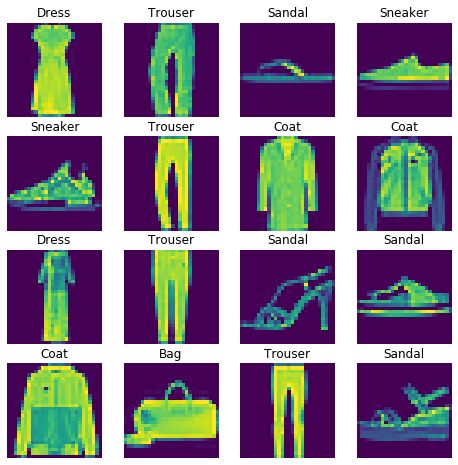

In [9]:
fig, axes = plt.subplots(4, 4, figsize = (8,8))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = df.drop('label', axis=1).values[index].reshape(28,28)
        cloths = df['label'][index]
        axe.imshow(img)             # for gray scaled image just include cmap='gray'
        axe.set_title(clothes[cloths])
        axe.set_axis_off()

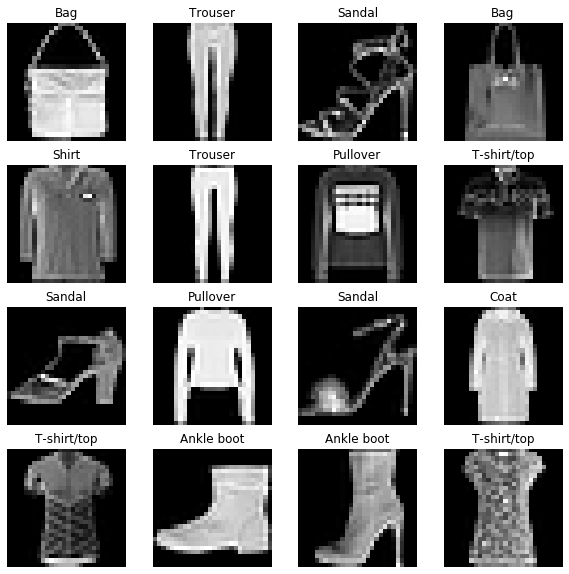

In [10]:
# for gray scaled image and say a little larger images-

fig, axes = plt.subplots(4, 4, figsize = (10,10))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = df.drop('label', axis=1).values[index].reshape(28,28)
        cloths = df['label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothes[cloths])
        axe.set_axis_off()

Looking at the Distribution of labels to anaylze if there are any skewed classes i.e if no. of training examples in 
one class heavily outnumbers the no. of training examples of another class

In [11]:
df['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

So, we see, there are no skewed classes

# PLOTTING THE DATA 

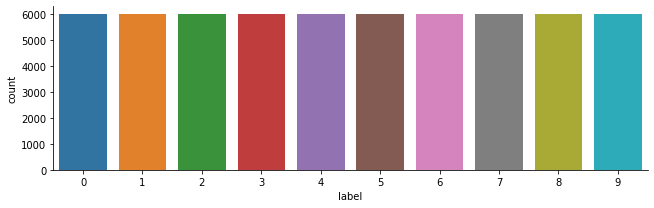

In [13]:
sns.catplot(x='label', data=df, kind='count', height=3, aspect= 3)

We can see that all classes are equaly distributed so, there are no anomalies in the dataset

Now, seeting random seed for reproducibility

In [12]:
seed = 66
np.random.seed(seed)

# SPLITTING DATA INTO TRAIN-TEST DATASETS

In [13]:
from tensorflow.keras.datasets import fashion_mnist
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

In [14]:
trainX.shape

(60000, 28, 28)

In [15]:
testX.shape

(10000, 28, 28)

### Reshaping the data


mnist.load_data() supplies the MNIST digits with structure (nb_samples, 28, 28) i.e. with 2 dimensions per example representing a greyscale image 28x28.The Convolution2D layers in Keras however, are designed to work with 3 dimensions per example. They have 4-dimensional inputs and outputs. This covers colour images (nb_samples, nb_channels, width, height), but more importantly, it covers deeper layers of the network, where each example has become a set of feature maps i.e. (nb_samples, nb_features, width, height).

The greyscale image for MNIST digits input would either need a different CNN layer design (or a param to the layer constructor to accept a different shape), or the design could simply use a standard CNN and you must explicitly express the examples as 1-channel images. The Keras team chose the latter approach, which needs the re-shape.

In [16]:
trainX = trainX.reshape((trainX.shape[0], 1, 28, 28))
testX = testX.reshape((testX.shape[0], 1, 28, 28))

In [17]:
print(trainX.shape)
print(testX.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


# BUILDING THE MODEL

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [19]:
# build the model
# input layers
model = tf.keras.models.Sequential()   # sequential is the most common type of model
model.add(tf.keras.layers.Flatten())    # to flatten our image

# hidden layers
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))     # Dense(no. of nuerons in layer, activation function)
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
#output layer
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))   # softmax for probability distribution

#architecture of model is complete 
#parameters for model training
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])   # loss for error

history = model.fit(trainX, trainY, validation_data = (testX, testY) , epochs=100)

Epoch 1/100
1875/1875 [==============================] - 12s 6ms/step - loss: 1.0760 - accuracy: 0.7635 - val_loss: 0.5611 - val_accuracy: 0.7907
Epoch 2/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.4762 - accuracy: 0.8289 - val_loss: 0.5207 - val_accuracy: 0.8261
Epoch 3/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4384 - accuracy: 0.8431 - val_loss: 0.4694 - val_accuracy: 0.8318
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4038 - accuracy: 0.8564 - val_loss: 0.4549 - val_accuracy: 0.8346
Epoch 5/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3769 - accuracy: 0.8651 - val_loss: 0.4174 - val_accuracy: 0.8536
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3689 - accuracy: 0.8685 - val_loss: 0.4443 - val_accuracy: 0.8408
Epoch 7/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3568 - accuracy: 0.8729 - val_loss: 0.3913 - 

Epoch 57/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2617 - accuracy: 0.9144 - val_loss: 0.4660 - val_accuracy: 0.8824
Epoch 58/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2434 - accuracy: 0.9135 - val_loss: 0.4783 - val_accuracy: 0.8707
Epoch 59/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2463 - accuracy: 0.9145 - val_loss: 0.5649 - val_accuracy: 0.8805
Epoch 60/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2485 - accuracy: 0.9134 - val_loss: 0.5480 - val_accuracy: 0.8764
Epoch 61/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2343 - accuracy: 0.9160 - val_loss: 0.5305 - val_accuracy: 0.8747
Epoch 62/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2337 - accuracy: 0.9161 - val_loss: 0.5305 - val_accuracy: 0.8822
Epoch 63/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2345 - accuracy: 0.9157 - val_loss: 0.7527

In [22]:
# we can see above that loss dropped and accuracy increased with each epoch

In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


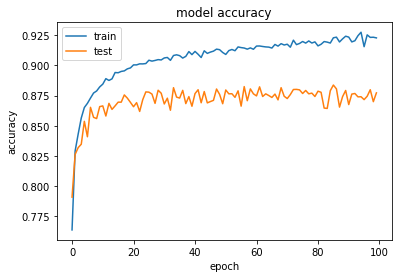

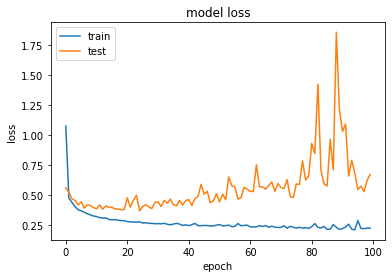

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# EVALUATING THE MODEL

In [23]:
val_loss, val_acc= model.evaluate(testX, testY)
print(val_loss, val_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.6723 - accuracy: 0.8772
0.6722598671913147 0.8772000074386597


### Thus, we get an accuracy of 87.72 % 

# PREDICTIONS

In [27]:
 #get the predictions for the test data
predicted_classes = model.predict_classes(testX)

In [26]:
test_img = testX[0]
prediction = model.predict(testX)
prediction[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0679664e-18, 0.0000000e+00, 9.9925086e-12,
       0.0000000e+00, 1.0000000e+00], dtype=float32)

In [28]:
np.argmax(prediction[0])

9

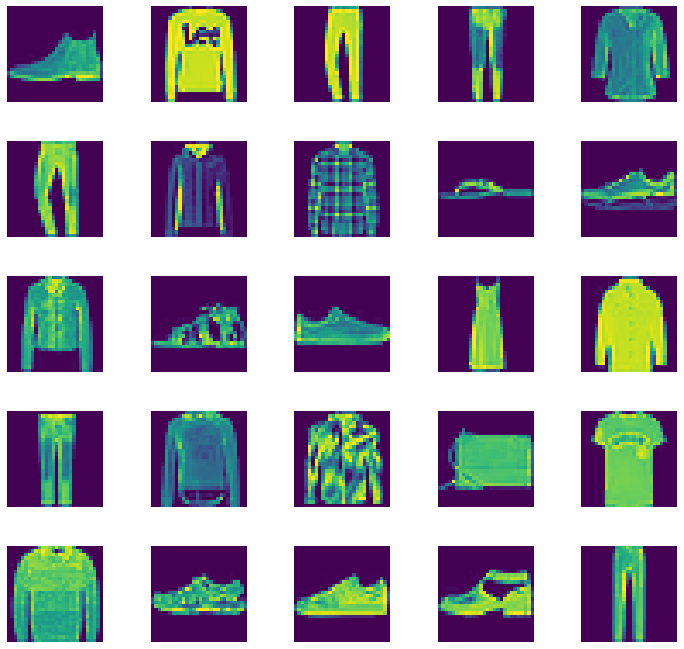

In [30]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(testX[i].reshape(28,28))
    #axes[i].set_title(f"Prediction Class = {predicted_classes[i]:0.1f}\n True Class = {y_test[i]:0.1f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# MAKING THE CONFUSION MATRIX

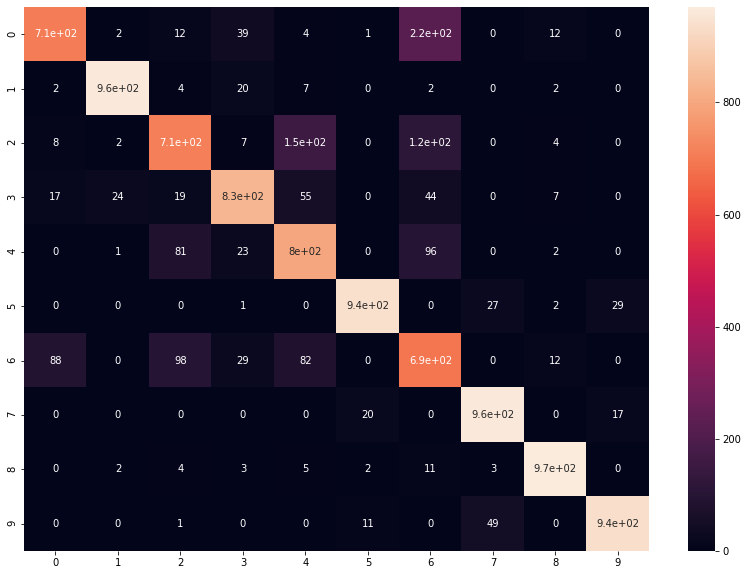

In [31]:
from sklearn.metrics import confusion_matrix
cmatrix = confusion_matrix(testY, predicted_classes)
plt.figure(figsize = (14,10))
sns.heatmap(cmatrix, annot=True)
# Sum the diagonal element to get the total true correct values

We can see that there is no negative correlation

# CLASSIFICATION REPORT

In [29]:
from sklearn.metrics import classification_report

num_classes = 10
target_names = [f"Class {i}" for i in range(num_classes)]

print(classification_report(testY, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.83      0.83      0.83      1000
     Class 1       0.99      0.97      0.98      1000
     Class 2       0.76      0.83      0.79      1000
     Class 3       0.80      0.93      0.86      1000
     Class 4       0.84      0.72      0.77      1000
     Class 5       0.97      0.96      0.97      1000
     Class 6       0.74      0.65      0.69      1000
     Class 7       0.94      0.95      0.95      1000
     Class 8       0.95      0.97      0.96      1000
     Class 9       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

